## Summarization with HuggingFace | NLP Projects

Summarization in Natural Language Processing (NLP) involves the automatic generation of concise and coherent summaries from longer texts or documents.


## Coding

https://huggingface.co/

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/13/9e/ee987874058f2d93006961f6ff49e0bcb60ab9c26709ebe06bfa8707a4d8/accelerate-0.24.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/e2/cf/db41e572d7ed958e8679018f8190438ef700aeb501b62da9e1eed9e4d69a/datasets-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/36/9d/fed46a4d94d05bc400bdaeb02d277ca5e61965cebe25b6029990d2191c0b/pyarrow_hotfix-0.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 2.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.12.0
    Uninstalling datasets-2.12.0:
      Successfully uninstalled datasets-2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Fine-Tuning Summarization Model on Custom Dataset

https://huggingface.co/datasets/samsum

In [1]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [ ]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [2]:
samsum = load_dataset('samsum')
samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

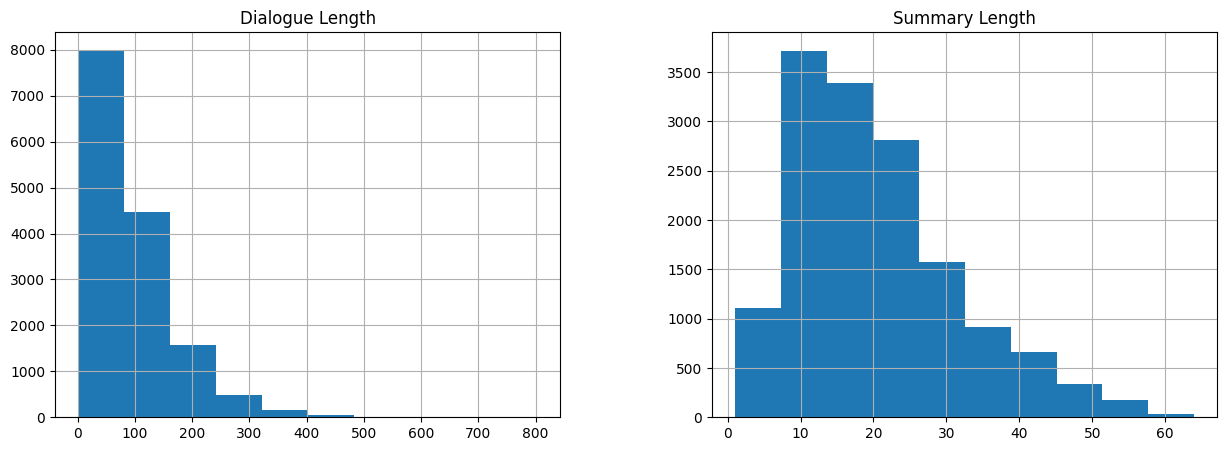

In [ ]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))

In [ ]:
# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [ ]:
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

In [ ]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=1.4828218460083007, metrics={'train_runtime': 1775.4509, 'train_samples_per_second': 8.298, 'train_steps_per_second': 0.13, 'total_flos': 8823772719611904.0, 'train_loss': 1.4828218460083007, 'epoch': 1.0})

In [ ]:
trainer.save_model('bart_samsum_model')

In [3]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 128, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


[{'summary_text': "Juli wants to send Tom on a business trip first. She will assign him a new project once he is back. Tom did excellent in last quarter and she wants to give him more work. Laxmi Kant doesn't have any suitable work for him."}]


In [ ]:
!zip bart_samsum.zip -r bart_samsum_model/

  adding: bart_samsum_model/ (stored 0%)
  adding: bart_samsum_model/merges.txt (deflated 53%)
  adding: bart_samsum_model/config.json (deflated 61%)
  adding: bart_samsum_model/tokenizer_config.json (deflated 76%)
  adding: bart_samsum_model/special_tokens_map.json (deflated 52%)
  adding: bart_samsum_model/training_args.bin (deflated 51%)
  adding: bart_samsum_model/generation_config.json (deflated 48%)
  adding: bart_samsum_model/vocab.json (deflated 59%)
  adding: bart_samsum_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_model/model.safetensors (deflated 7%)


In [6]:
from rouge_score import rouge_scorer

def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    rouge_scores = {
        'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
        'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
        'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0},
    }

    for pred, ref in zip(predictions, references):
        scores = scorer.score(pred, ref)
        for metric, values in scores.items():
            for measure, value in values.items():
                rouge_scores[metric][measure] += value

    num_examples = len(predictions)
    for metric in rouge_scores:
        for measure in rouge_scores[metric]:
            rouge_scores[metric][measure] /= num_examples

    return rouge_scores

In [5]:
import json

# Load the validation data from val.json
with open('val.json', 'r') as f:
    val_data = json.load(f)

# Extract dialogues and references
dialogues = [item['dialogue'] for item in val_data]
references = [item['summary'] for item in val_data]

# Generate summaries using the fine-tuned model
generated_summaries = []
for dialogue in dialogues:
    summary = pipe(dialogue, **gen_kwargs)[0]['summary_text']
    generated_summaries.append(summary)




Your max_length is set to 128, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
Your max_length is set to 128, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Your max_length is set to 128, but your input_length is only 75. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 128, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your

NameError: name 'calculate_rouge_scores' is not defined

In [13]:
from rouge_score import rouge_scorer

def calculate_metrics(generated_summaries, references):
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    # Initialize total scores
    total_scores = {'rouge1': {'fmeasure': 0, 'precision': 0, 'recall': 0},
                    'rouge2': {'fmeasure': 0, 'precision': 0, 'recall': 0},
                    'rougeL': {'fmeasure': 0, 'precision': 0, 'recall': 0}}
    
    # Calculate scores for each example
    for generated, reference in zip(generated_summaries, references):
        rouge_scores = rouge_scorer_instance.score(generated, reference)
        
        # Sum up scores for each metric
        for metric, values in rouge_scores.items():
            total_scores[metric]['fmeasure'] += values.fmeasure
            total_scores[metric]['precision'] += values.precision
            total_scores[metric]['recall'] += values.recall
    
    # Calculate average scores
    num_examples = len(generated_summaries)
    average_scores = {metric: {measure: total / num_examples for measure, total in values.items()} for metric, values in total_scores.items()}
    
    return average_scores



metrics = calculate_metrics(generated_summaries, references)
print(metrics)


{'rouge1': {'fmeasure': 0.3872323879631765, 'precision': 0.7244427982753698, 'recall': 0.2779618523270327}, 'rouge2': {'fmeasure': 0.20217471574036652, 'precision': 0.40507906681016853, 'recall': 0.14316920670296565}, 'rougeL': {'fmeasure': 0.3128022271513192, 'precision': 0.5940132534753677, 'recall': 0.22340771518352492}}


In [17]:
from sacrebleu import corpus_bleu



# Compute BLEU score
bleu = corpus_bleu(generated_summaries, references)
print(f"BLEU Score: {bleu.score}")


BLEU Score: 0.056914507624718905


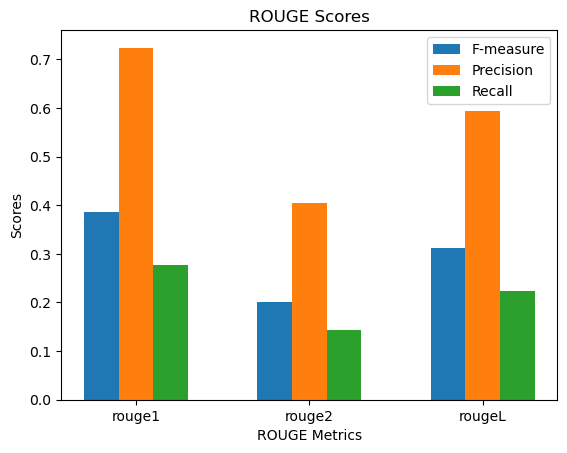

In [19]:
import matplotlib.pyplot as plt

# Assuming you have the rouge_scores dictionary
rouge_scores = {
    'rouge1': {'fmeasure': 0.387, 'precision': 0.724, 'recall': 0.278},
    'rouge2': {'fmeasure': 0.202, 'precision': 0.405, 'recall': 0.143},
    'rougeL': {'fmeasure': 0.313, 'precision': 0.594, 'recall': 0.223},
}

# Extract metrics and scores
metrics = list(rouge_scores.keys())
fmeasures = [score['fmeasure'] for score in rouge_scores.values()]
precisions = [score['precision'] for score in rouge_scores.values()]
recalls = [score['recall'] for score in rouge_scores.values()]

# Plotting
bar_width = 0.2
index = range(len(metrics))
fig, ax = plt.subplots()

plt.bar(index, fmeasures, bar_width, label='F-measure')
plt.bar([i + bar_width for i in index], precisions, bar_width, label='Precision')
plt.bar([i + 2 * bar_width for i in index], recalls, bar_width, label='Recall')

plt.xlabel('ROUGE Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores')
plt.xticks([i + bar_width for i in index], metrics)
plt.legend()

plt.show()
